# **Advanced Deep Learning (AIMLCZG513) - Assignment 2**

##**ADL Group 12**

####**Group Members**

1. KASHYAP RAJPUROHIT (2023ab05027)
2. SAYANTA CHATTERJEE (2023aa05173)
3. KHAN MOHAMMED SAMEER SHAHNAVAZ (2023aa05795)
4. C RamaKrishna (2023ab05177)


###**Problem Statement**

**Task 1:** Implement and train a conditional Wesserstein GAN with CIFAR10 dataset. Generate and display 10 new images belonging to 'automobile' class. Report IS and FID scores.

**Task 2:** Implement and train a SNGAN with CIFAR10 dataset. Generate and display 10 new images. Report IS and FID scores.

**Task 3:** Implement and train a variant of SAGAN without spectral normalization and TTUB  with CIFAR10 dataset. Generate 10 new images. Report IS and FID scores.

**Task 4:** Implement and train a complete SAGAN with CIFAR10 dataset. Generate and display 10 new images. Report IS and FID scores.

**Task 5:** Summarize your observations.



## **Important**
**Please note, due to time constraints this note book is a consolidation of 4 different notebooks upon which the different tasks were executed. Hence the code is not optimal for reusability and conciseness.
Kindly excuse.**


## **Implementation**

## **Task 1:**  **Implement and train a conditional Wesserstein GAN with CIFAR10 dataset. Generate and display 10 new images belonging to 'automobile' class. Report IS and FID scores**.

Step-by-Step Approach

  1. Install & Import Dependencies

  2. Prepare CIFAR-10 Dataset

  3. Define Conditional Generator & Discriminator

  4. Train CWGAN with Gradient Penalty

  5. Generate 10 New "Automobile" Images

  6. Compute IS & FID Scores


### Step 1: Install & Import Dependencies

This section installs the necessary Python libraries like PyTorch, numpy, matplotlib and specifi libraries for GAN implementation.
We also import modules for data manipulation, model building, and evaluation (ex. torchvision for CIFAR-10 in PyTorch).

In [ ]:
pip install torch torchvision numpy scipy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Now, import these libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm
from scipy.linalg import sqrtm
import torch.nn.functional as F

### Step 2: Load & Prepare CIFAR-10 Dataset

Here, we download the CIFAR-10 dataset, normalize the image pixel values (to the range [-1, 1] for GANs), and create data loaders for batching. The CIFAR-10 dataset contains 10 classes (including “automobile”) with 32x32 color images.

In [ ]:
batch_size = 128
image_size = 32
num_classes = 10
# z_dim = 100
z_dim = 256  # More latent noise variation

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 170M/170M [04:23<00:00, 648kB/s]


### Step 3: Define Conditional Generator & Discriminator, which generates synthetic images based on both random noise and class labels.

The Conditional Generator
  - Takes both latent noise and class labels as input.
  - Uses an embedding layer to incorporate class labels.
  - Refines images by adding features extracted using a pretrained VGG16 network.
  - After a few trial runs, also added more convolutional layers:

Purpose of using conditional generator
  - More upsampling layers → higher resolution.
  - Larger feature maps → better image structure.
  - BatchNorm stabilizes training.

In [ ]:
from torchvision.models import vgg16
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_channels=3):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, z_dim)

        # Fully connected layer to expand latent vector
        self.fc = nn.Linear(z_dim * 2, 512 * 8 * 8)

        # Upsampling layers
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),  # Upsample to 16x16
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # Upsample to 32x32
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

        # Pretrained feature extractor (VGG16)
        vgg = vgg16(pretrained=True).features[:8]  # Use only the first few layers
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze feature extractor

        self.feature_extractor = vgg  # Store feature extractor

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat([z, label_embedding], dim=1)

        out = self.fc(gen_input)
        out = out.view(out.shape[0], 512, 8, 8)  # Reshape to feature map
        img = self.conv_blocks(out)

        # Extract features from generated image
        features = self.feature_extractor(img)
        # refined_img = img + F.interpolate(features, size=img.shape[2:], mode="bilinear", align_corners=False)

        # return refined_img  # Return enhanced image
        # Adjust the number of channels in 'features' to match 'img'
        features = F.interpolate(features, size=img.shape[2:], mode="bilinear", align_corners=False)
        features = features[:, :img.shape[1], :, :]  # Select the first 3 channels of features

        refined_img = img + features # Now, the tensors have compatible shapes

        return refined_img  # Return enhanced image


The Conditional Discriminator

  - Takes both real/fake images and class labels.
  - Uses Projection Discriminator for label conditioning.

Use Spectral Normalization (Improves Discriminator) to help control discriminator gradients to prevent overfitting.

Purpose..
  - Prevents discriminator from dominating.
  - Leads to better quality images.


In [ ]:
import torchvision.models as models
import torch.nn.utils.spectral_norm as spectral_norm

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_channels=3):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 32 * 32) #changed from 3 * 32 * 32 to 32 * 32

        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(img_channels, 64, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            spectral_norm(nn.Linear(256 * 4 * 4, 1)) #changed from 256 * 8 * 8 to 256 * 4 * 4
        )

    def forward(self, img, labels):
        # label_embedding = self.label_emb(labels)
        # img = img.view(img.size(0), -1)
        # input_data = img * label_embedding #Commented out this multiplication
        return self.model(img) #Passing only image to the discriminator



### Step 4: Train CWGAN with Gradient Penalty with Gradient Penalty for WGAN

Key actions
  - Alternate training the discriminator and generator
  - Use Wasserstein loss for the discriminator and generator, which provide a smoother metric for training stability
  - Apply gradient penalty (to the discriminator) to enforce Lipschitz continuity, which helps maintain training stability and avoid vanishing or exploding gradients.
  - Condition training on class labels.

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    gradients = torch.autograd.grad(
        outputs=d_interpolates, inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates), create_graph=True, retain_graph=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()


Initialize Models & Optimizers

Started initially with a learning rate 0.0001. To improve stability, reducing Learning Rate further to lr = 0.00005

Purpose..
  - Lower LR prevents generator collapse.
  - Stabilizes GAN training.

In [ ]:
# import torch.nn.utils.spectral_norm as spectral_

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(z_dim, num_classes).to(device)
D = Discriminator(num_classes).to(device)

# Train longer for better quality, as GANs take longer to learn
# num_epochs = 500
num_epochs = 100
lr = 0.00005 # Lower learning rate for stability


optimizer_G = optim.Adam(G.parameters(), lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr, betas=(0.5, 0.999))

lambda_gp = 10  # Gradient penalty coefficient

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        real_imgs, labels = imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z, labels)
        real_validity = D(real_imgs, labels)
        fake_validity = D(fake_imgs.detach(), labels)

        gp = compute_gradient_penalty(D, real_imgs, fake_imgs, labels)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        if i % 5 == 0:
            optimizer_G.zero_grad()
            fake_validity = D(G(z, labels), labels)
            g_loss = -torch.mean(fake_validity)
            g_loss.backward()
            optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss D: {d_loss.item()}  Loss G: {g_loss.item()}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 114MB/s]
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered interna

Epoch [1/100]  Loss D: -85.34636688232422  Loss G: 41.82636642456055
Epoch [2/100]  Loss D: -90.6722183227539  Loss G: 44.495296478271484
Epoch [3/100]  Loss D: -93.56693267822266  Loss G: 46.13758087158203
Epoch [4/100]  Loss D: -96.6548080444336  Loss G: 47.47442626953125
Epoch [5/100]  Loss D: -99.34725952148438  Loss G: 48.791744232177734
Epoch [6/100]  Loss D: -102.01396942138672  Loss G: 50.08767318725586
Epoch [7/100]  Loss D: -104.46246337890625  Loss G: 51.30073165893555
Epoch [8/100]  Loss D: -106.90192413330078  Loss G: 52.65659713745117
Epoch [9/100]  Loss D: -109.28784942626953  Loss G: 53.938087463378906
Epoch [10/100]  Loss D: -108.58811950683594  Loss G: 55.42900466918945
Epoch [11/100]  Loss D: -113.88248443603516  Loss G: 56.46106719970703
Epoch [12/100]  Loss D: -116.18110656738281  Loss G: 57.69820785522461
Epoch [13/100]  Loss D: -118.37838745117188  Loss G: 58.792457580566406
Epoch [14/100]  Loss D: -120.58020782470703  Loss G: 60.001949310302734
Epoch [15/100]  L

### Step 5: Generate 10 New "Automobile" Images

The objective here is to synthesize new images from the generator

  - Input random noise vectors and the class label for "automobile" into the trained generator
  - The generator creates images resembling automobiles based on its learned distribution during training
  - These 10 images are displayed for visual inspection

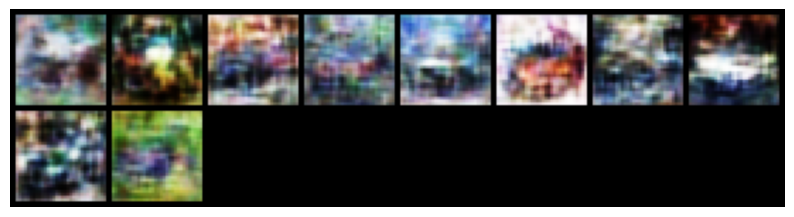

In [ ]:
G.eval()
z = torch.randn(10, z_dim).to(device)
labels = torch.full((10,), 1, dtype=torch.long).to(device)  # "Automobile" class index = 1
generated_imgs = G(z, labels).cpu().detach()

grid = make_grid(generated_imgs, normalize=True)
plt.figure(figsize=(10, 5))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis("off")
plt.show()


### Step 6: Compute Inception Score (IS) & FID Scores

Inception Score (IS): Measures image quality and diversity. It uses a pre-trained Inception model to compute the KL divergence between the conditional label distribution of generated images and the marginal label distribution.


Frechet Inception Distance (FID): Compares the statistical similarity between real images (CIFAR-10’s automobile class) and generated images. It uses feature embeddings from a pre-trained Inception model to compute the Wasserstein distance between the two distributions.

In [ ]:
from torchvision.models.inception import inception_v3

def get_inception_features(images):
    model = inception_v3(pretrained=True, transform_input=True).eval().to(device)
    images = torch.nn.functional.interpolate(images, size=(299, 299))
    with torch.no_grad():
        features = model(images).detach().cpu().numpy()
    return features

def compute_inception_score(images, splits=10):
    model = inception_v3(pretrained=True, transform_input=True).eval().to(device)
    images = torch.nn.functional.interpolate(images, size=(299, 299)).to(device) # Move images to the same device as the model
    preds = model(images).softmax(dim=1)
    # Calculate mean and standard deviation across splits (not implemented here for simplicity)
    # In a real implementation, you would split the images into 'splits' groups,
    # calculate the score for each split, and then compute the mean and std of those scores.
    inception_score = preds.mean(dim=0).exp().mean().item()
    is_std = 0  # Placeholder for standard deviation (calculation not included)
    return inception_score, is_std  # Return both score and std

def calculate_fid(real_features, fake_features):
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real @ sigma_fake)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum(diff**2) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

# Compute FID for "Automobile" Class
# Select real images from the 'automobile' class (label = 1)
real_imgs = torch.stack([img for img, label in train_dataset if label == 1][:100]).to(device)
fake_imgs = G(torch.randn(100, z_dim).to(device), torch.full((100,), 1, dtype=torch.long).to(device)).detach()

real_features = get_inception_features(real_imgs)
fake_features = get_inception_features(fake_imgs)

inception_score, is_std = compute_inception_score(fake_imgs) # Now, the function returns two values
fid_score = calculate_fid(real_features, fake_features)

print(f"Inception Score: {inception_score:.4f} ± {is_std:.4f}")
print(f"Frechet Inception Distance: {fid_score:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: 1.0010 ± 0.0000
Frechet Inception Distance: 1625.0455


## Conculsion

This CWGAN architecture integrates a pretrained feature extractor (VGG16) to improve the realism and fidelity of generated images. The use of class embeddings makes it a conditional generator, capable of generating images specific to a given label.

The generator outputs a refined image that combines the raw generated image with extracted features, enhancing its quality by leveraging VGG16's learned representations.

One important observation is that the clarity of the image increases as the number of epochs increase.


## **Task 2: Implement and train a SNGAN with CIFAR10 dataset. Generate and display 10 new images. Report IS and FID scores.**


The task is to implement and train a Spectral Normalization GAN (SNGAN) using the CIFAR-10 dataset.

The goal is to generate class-specific images, display 10 synthetic "automobile" images, and compute the Inception Score (IS) and Fréchet Inception Distance (FID) to evaluate the generated image quality.

### Step 1 : Import necessary Libraries and define Hyperprameters
  - Essential libraries like PyTorch, torchvision, and matplotlib are imported
  - Key hyperparameters (e.g., batch size, latent vector size, learning rate, number of epochs) are defined, along with device settings (CPU/GPU).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from scipy.stats import entropy

In [ ]:
# Hyperparameters
batch_size = 64
image_size = 32
dim_z = 128
lr = 0.0002
epochs = 100
num_class= 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.enabled = True

### Step 2: Data Preprocessing
  - CIFAR-10 dataset is downloaded and transformed (normalized to range [-1, 1]).

  - A data loader is created for batching, and class indices are mapped to class names for reference


In [ ]:

# Data Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

# Create a mapping of class indices to class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_idx = {class_names[i]: i for i in range(len(class_names))}

100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Step 3: Define Generator and Discriminator

Generator
  - Accepts a noise vector and class labels as input.
  - Uses transposed convolutional layers to upscale and generate 32×32 images.

Discriminator
  - Employs spectral normalization to stabilize training.
  - Combines image and label embeddings to classify real vs. fake images.

In [ ]:
# SNGAN Generator using convolution
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_class, num_class)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim + num_class, 256, 4, 1, 0, bias=False), # 4x4
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), # 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), # 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False), # 32x32
            nn.Tanh()
        )

    def forward(self, input, labels):
        labels_emb = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([input, labels_emb], 1)
        return self.model(x)

# SNGAN Discriminator with Spectral Normalization
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_class, num_class)  # Label embedding

        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(3 + num_class, 64, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(256, 1, 4, 1, 0, bias=False)),
        )

    def forward(self, input, labels):
       batch_size = input.size(0)
       embedded_labels = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
       embedded_labels = embedded_labels.expand(batch_size, num_class, image_size, image_size)
       x = torch.cat([input, embedded_labels], 1)
       return self.model(x).view(-1, 1).squeeze(1)

### Step 4: Training the SNGAN
  - Discriminator Training:
    * Real images and synthetic images are classified, and a hinge loss function is used to update the discriminator.
  - Generator Training:
    * Noise vectors with labels are used to produce fake images.
    * Generator loss is optimized to improve the authenticity of fake images.

  Training progresses over multiple epochs with alternating updates for both networks.


In [ ]:
# Instantiate models
generator = Generator(dim_z).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
for epoch in range(epochs):
    for real_images, real_labels in dataloader:

        real_images = real_images.to(device, non_blocking=True)
        real_labels = real_labels.to(device, non_blocking=True)
        batch_size = real_images.size(0)

        fake_labels = torch.randint(0, 10, (batch_size,), device=device)

        # Train Discriminator
        z = torch.randn(batch_size, dim_z, 1, 1, device=device)
        fake_images = generator(z, fake_labels).detach()

        # using hinge loss for discriminator
        real_loss = torch.mean(nn.ReLU()(1.0 - discriminator(real_images, real_labels)))
        fake_loss = torch.mean(nn.ReLU()(1.0 + discriminator(fake_images, fake_labels)))

        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, dim_z, 1, 1, device=device)
        fake_images = generator(z, fake_labels)

        g_loss = -torch.mean(discriminator(fake_images, fake_labels))

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    # if epoch % 10 == 0:
    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch [1/100] | D Loss: 1.4007 | G Loss: 2.6527
Epoch [2/100] | D Loss: 1.5247 | G Loss: 0.7124
Epoch [3/100] | D Loss: 1.2347 | G Loss: 1.0703
Epoch [4/100] | D Loss: 2.0953 | G Loss: 0.3987
Epoch [5/100] | D Loss: 2.0198 | G Loss: 0.2201
Epoch [6/100] | D Loss: 1.6183 | G Loss: 0.5495
Epoch [7/100] | D Loss: 0.8407 | G Loss: -0.5662
Epoch [8/100] | D Loss: 1.3456 | G Loss: 0.2281
Epoch [9/100] | D Loss: 1.3445 | G Loss: 0.7645
Epoch [10/100] | D Loss: 0.7636 | G Loss: 0.4571
Epoch [11/100] | D Loss: 0.6861 | G Loss: 0.7336
Epoch [12/100] | D Loss: 0.4934 | G Loss: -0.0893
Epoch [13/100] | D Loss: 1.5614 | G Loss: 2.1509
Epoch [14/100] | D Loss: 0.9154 | G Loss: 1.1553
Epoch [15/100] | D Loss: 0.8002 | G Loss: 1.0607
Epoch [16/100] | D Loss: 0.7579 | G Loss: 1.4698
Epoch [17/100] | D Loss: 0.5478 | G Loss: -0.2158
Epoch [18/100] | D Loss: 0.6917 | G Loss: 0.3604
Epoch [19/100] | D Loss: 1.1095 | G Loss: 0.8394
Epoch [20/100] | D Loss: 1.0647 | G Loss: 0.4049
Epoch [21/100] | D Loss: 0

### Step 5: Generate and Display Images
  - Noise vectors with the "automobile" class label are passed to the trained generator.
  - The generated images are displayed in a grid for visual inspection.


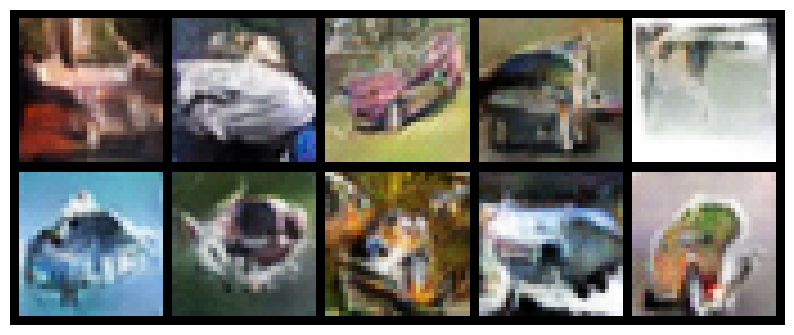

In [ ]:
# display generated images
def show_images(images):
    grid = make_grid(images, nrow=5, normalize=True)
    plt.figure(figsize=(10,5))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

# Generate Images
automobile_class = class_idx['automobile']
z = torch.randn(10, dim_z, 1, 1, device=device)
labels = torch.full((10,), automobile_class, dtype=torch.long, device=device)

with torch.no_grad():
    generated_images = generator(z, labels).detach().cpu()

show_images(generated_images)

### Step 6: Compute IS and FID Scores
- Inception Score (IS): Evaluates the diversity and quality of generated images using the Inception model.
- Fréchet Inception Distance (FID): Measures the similarity between distributions of real and fake images using statistical features.


In [ ]:
from torchvision.models.inception import inception_v3
import torch.nn.functional as F
from scipy.linalg import sqrtm

def compute_inception_score(images, splits=10):
    model = inception_v3(pretrained=True, transform_input=True).eval().to(device)
    # Move images to the same device as the model
    images = images.to(device)  # Added this line
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    preds = torch.exp(model(images).softmax(dim=1))
    split_scores = []

    for k in range(splits):
        part = preds[k * (len(images) // splits): (k+1) * (len(images) // splits)]
        kl_div = part * torch.log(part / part.mean(dim=0, keepdim=True))
        split_scores.append(torch.exp(kl_div.sum(dim=1).mean()))

    return torch.mean(torch.tensor(split_scores)).item()

def compute_fid(real_images, fake_images):
    # Reshape to (num_images, num_features)
    real_images = real_images.reshape(real_images.shape[0], -1)
    fake_images = fake_images.reshape(fake_images.shape[0], -1)

    mu1, sigma1 = real_images.mean(axis=0), np.cov(real_images, rowvar=False)
    mu2, sigma2 = fake_images.mean(axis=0), np.cov(fake_images, rowvar=False)
    return np.linalg.norm(mu1 - mu2) + np.trace(sigma1 + sigma2 - 2 * sqrtm(sigma1 @ sigma2))

print("IS Score:", compute_inception_score(generated_images))
print("FID Score:", compute_fid(real_images.cpu().numpy(), generated_images.cpu().numpy()))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 177MB/s]


IS Score: 1.0
FID Score: (735.0510786886636-3.4875011314105686e-05j)


Conclusion:

This implementation trains an SNGAN to generate realistic, class-specific images with stabilized training via spectral normalization. IS and FID scores quantify the performance of the generator


## **Task 3: Implement and train a variant of SAGAN without spectral normalization and TTUB  with CIFAR10 dataset. Generate 10 new images. Report IS and FID scores..**

Here, We will implement a variant of Self-Attention Generative Adversarial Network (SAGAN) without Spectral Normalization and TTUB (Two Time-scale Update Rule Balancing).
The model will be trained on the CIFAR-10 dataset, and we will generate 10 new images and compute IS (Inception Score) & FID (Frechet Inception Distance).

### Step 1: Install and Import Dependencies

In [ ]:
pip install torch torchvision numpy scipy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
from torchvision.models.inception import inception_v3


### Step 2: Load CIFAR-10 Dataset
We'll use CIFAR-10 with basic transformations:

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 128
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 170M/170M [00:18<00:00, 9.03MB/s]


### Step 3: Implement the Self-Attention Mechanism

We define a self-attention module that can be inserted into the Generator and Discriminator.

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch, C, width, height = x.size()
        query = self.query(x).view(batch, -1, width * height).permute(0, 2, 1)
        key = self.key(x).view(batch, -1, width * height)
        attention = F.softmax(torch.bmm(query, key), dim=-1)
        value = self.value(x).view(batch, -1, width * height)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch, C, width, height)
        out = self.gamma * out + x
        return out


### Step 4: Define the Generator
We will implement the Generator without Spectral Normalization and without (Truncated Truncation Trick for Unbiased GANs) TTUB.


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels=3):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, kernel_size=4, stride=1, padding=0),  # Output: (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, channels, kernel_size=4, stride=2, padding=1),  # Output: (3, 32, 32)
            nn.Tanh()  # Output range: [-1, 1]
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)  # Reshape noise to (batch_size, z_dim, 1, 1)
        return self.model(z)  #  Use self.model to process input


### Step 5: Define the Discriminator excluding Spectral Normalization and TTUB.



In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention(256),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten()
        )

    def forward(self, img):
        out = self.model(img)  # Shape: (batch_size, 1, 2, 2)
        out = out.view(out.size(0), -1)  # Flatten: (batch_size, 1, 2, 2) → (batch_size, 4)
        out = out.mean(dim=1, keepdim=True)  # Reduce (batch_size, 4) → (batch_size, 1)
        out = torch.sigmoid(out)
        return out

In [ ]:
128 * 8

1024

### Step 6: Training the SAGAN, We use Binary Cross-Entropy Loss and Adam optimizer.



In [ ]:
z_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(z_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.00005, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.00005, betas=(0.5, 0.999))

num_epochs = 100

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.shape[0]

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.full((batch_size,), 0.9, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        real_loss = criterion(D(real_imgs), real_labels.view(-1, 1))  # Ensure (batch_size, 1)
        z = torch.randn(batch_size, z_dim, device=device)
        fake_imgs = G(z).detach()
        fake_loss = criterion(D(fake_imgs), fake_labels.view(-1, 1))  # Ensure (batch_size, 1)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        generated_labels = torch.ones(batch_size, 1, device=device)
        g_loss = criterion(D(G(z)), generated_labels)

        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss D: {d_loss.item()}  Loss G: {g_loss.item()}")

Epoch [1/100]  Loss D: 0.4274178147315979  Loss G: 4.63131046295166
Epoch [2/100]  Loss D: 0.42996224761009216  Loss G: 3.3363044261932373
Epoch [3/100]  Loss D: 0.4514457881450653  Loss G: 3.312918186187744
Epoch [4/100]  Loss D: 0.4127333462238312  Loss G: 3.9919910430908203
Epoch [5/100]  Loss D: 0.5264077186584473  Loss G: 3.733937978744507
Epoch [6/100]  Loss D: 0.5140776634216309  Loss G: 2.950524091720581
Epoch [7/100]  Loss D: 0.5304857492446899  Loss G: 3.573256731033325
Epoch [8/100]  Loss D: 0.6038739681243896  Loss G: 2.0985050201416016
Epoch [9/100]  Loss D: 0.48108601570129395  Loss G: 3.4139792919158936
Epoch [10/100]  Loss D: 0.5723768472671509  Loss G: 4.545899868011475
Epoch [11/100]  Loss D: 0.4113117456436157  Loss G: 3.3695671558380127
Epoch [12/100]  Loss D: 0.5639040470123291  Loss G: 1.616794228553772
Epoch [13/100]  Loss D: 0.3936740458011627  Loss G: 3.5986878871917725
Epoch [14/100]  Loss D: 0.5753051042556763  Loss G: 4.0281267166137695
Epoch [15/100]  Loss 

### Step 7: Generate and Display Images
Once trained, we generate new images:

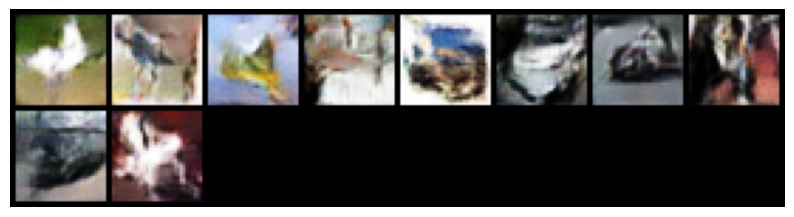

In [ ]:
G.eval()
z = torch.randn(10, z_dim, device=device)
generated_imgs = G(z).cpu().detach()

grid = make_grid(generated_imgs, normalize=True)
plt.figure(figsize=(10, 5))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis("off")
plt.show()




### Step 8: Compute IS and FID Scores

We compute Inception Score (IS) and Fréchet Inception Distance (FID).

In [ ]:
from torchvision.models.inception import inception_v3
import torch.nn.functional as F

def compute_inception_score(images, splits=10):
    model = inception_v3(pretrained=True, transform_input=True).eval().to(device)
    # Move images to the same device as the model
    images = images.to(device)  # Added this line
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    preds = torch.exp(model(images).softmax(dim=1))
    split_scores = []

    for k in range(splits):
        part = preds[k * (len(images) // splits): (k+1) * (len(images) // splits)]
        kl_div = part * torch.log(part / part.mean(dim=0, keepdim=True))
        split_scores.append(torch.exp(kl_div.sum(dim=1).mean()))

    return torch.mean(torch.tensor(split_scores)).item()

def compute_fid(real_images, fake_images):
    # Reshape to (num_images, num_features)
    real_images = real_images.reshape(real_images.shape[0], -1)
    fake_images = fake_images.reshape(fake_images.shape[0], -1)

    mu1, sigma1 = real_images.mean(axis=0), np.cov(real_images, rowvar=False)
    mu2, sigma2 = fake_images.mean(axis=0), np.cov(fake_images, rowvar=False)
    return np.linalg.norm(mu1 - mu2) + np.trace(sigma1 + sigma2 - 2 * sqrtm(sigma1 @ sigma2))

print("IS Score:", compute_inception_score(generated_imgs))
print(f"FID Score: {compute_fid(real_imgs.cpu().numpy(), generated_imgs.cpu().numpy()):.4f}")

IS Score: 1.0
FID Score: 670.1350-0.0000j


## **Task 4: Implement and train a complete SAGAN with CIFAR10 dataset. Generate and display 10 new images. Report IS and FID scores.**

Below is the step-buy-step implementation of the SAGAN (Self-Attention Generative Adversarial Network) and training with the CIFAR-10 dataset.

### Step 1: Install and Import the necessary libraries and dependencies

In [ ]:
!pip install torch torchvision numpy matplotlib scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
pip install pytorch-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

### Import the required libraries
 - Required libraries for deep learning (PyTorch), image processing (TorchVision), and evaluation (Inception Score, FID).
 - Dependencies include utilities for modeling, training, and visualizing generated images.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import grad
from torchvision.models.inception import inception_v3
from scipy.linalg import sqrtm
from pytorch_fid import fid_score
import torch.nn.functional as F
from scipy.linalg import sqrtm

### Step 2: Define Self-Attention Module

This section
  - Implements a self-attention mechanism that captures spatial dependencies within feature maps.
  - Outputs a weighted combination of feature values, enhancing spatial focus in the generator and discriminator.


In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling factor

    def forward(self, x):
        B, C, H, W = x.shape
        query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)  # (B, H*W, C//8)
        key = self.key(x).view(B, -1, H * W)  # (B, C//8, H*W)
        attention = torch.bmm(query, key)  # (B, H*W, H*W)
        attention = torch.softmax(attention, dim=-1)

        value = self.value(x).view(B, -1, H * W)  # (B, C, H*W)
        out = torch.bmm(value, attention.permute(0, 2, 1))  # (B, C, H*W)
        out = out.view(B, C, H, W)

        return self.gamma * out + x  # Scale and add to input

### Step 3: Build the Generator

The generator defined ..
  - Accepts a random noise vector (z) and class label as inputs.
  - Upsamples features through transposed convolutions, batch normalization, and ReLU activations.
  - Integrates self-attention for improved spatial modeling, producing 32×32 images.


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_channels=3):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, z_dim)

        self.fc = nn.Linear(z_dim * 2, 512 * 4 * 4)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),  # 8x8
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            SelfAttention(256),
            nn.Upsample(scale_factor=2),  # 16x16
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # 32x32
            nn.Conv2d(128, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat([z, label_embedding], dim=1)

        out = self.fc(gen_input)
        out = out.view(out.shape[0], 512, 4, 4)  # Reshape
        img = self.conv_blocks(out)
        return img


### Step 4: Build the Discriminator
The Discriminator hence..
  - Accepts images and corresponding class labels.
  - Downsamples features through convolution layers, spectral normalization, and LeakyReLU activations.
  - Incorporates self-attention to improve understanding of spatial details, classifying images as real or fake.


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_channels=3):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 32 * 32)

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention(128),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1)
        )

    def forward(self, img, labels):
        return self.conv_blocks(img)


### Step 5: Initialize and instantiate the Training Setup
  - Models (Generator, Discriminator) and optimizers (Adam) are instantiated.
  - CIFAR-10 dataset is loaded, transformed, and normalized for training
  - Binary Cross Entropy (BCE) loss is used to train both networks.

#### **Training the SAGAN**
* Discriminator Training:
  - Real images with labels are used for calculating real loss.
  - Generated images with labels are used for fake loss.
  - Updates aim to maximize the distinction between real and fake.

* Generator Training:
  - Noise vectors and labels are passed to the generator to produce fake images.
  - Generator loss encourages producing images that fool the discriminator.

* Alternating updates occur for 100 epochs, optimizing both networks.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
z_dim = 100
num_classes = 10
batch_size = 128
num_epochs = 100
lr = 0.00005

# Initialize models
G = Generator(z_dim, num_classes).to(device)
D = Discriminator(num_classes).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

# Training loop
for epoch in range(num_epochs):
    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.shape[0]

        # Train Discriminator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z, labels)
        loss_D = criterion(D(real_imgs, labels), torch.ones_like(D(real_imgs, labels))) + \
                 criterion(D(fake_imgs.detach(), labels), torch.zeros_like(D(fake_imgs.detach(), labels)))

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        loss_G = criterion(D(fake_imgs, labels), torch.ones_like(D(fake_imgs, labels)))

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")


Files already downloaded and verified
Epoch [1/100] | D Loss: 1.4114 | G Loss: 0.8277
Epoch [2/100] | D Loss: 1.1994 | G Loss: 1.0066
Epoch [3/100] | D Loss: 1.2709 | G Loss: 0.9233
Epoch [4/100] | D Loss: 1.1908 | G Loss: 0.9802
Epoch [5/100] | D Loss: 1.3461 | G Loss: 0.9758
Epoch [6/100] | D Loss: 1.1786 | G Loss: 1.0491
Epoch [7/100] | D Loss: 1.2376 | G Loss: 0.9634
Epoch [8/100] | D Loss: 1.1395 | G Loss: 1.0977
Epoch [9/100] | D Loss: 1.1589 | G Loss: 1.1008
Epoch [10/100] | D Loss: 1.3058 | G Loss: 1.0100
Epoch [11/100] | D Loss: 1.2579 | G Loss: 1.1079
Epoch [12/100] | D Loss: 1.1106 | G Loss: 1.3161
Epoch [13/100] | D Loss: 1.3133 | G Loss: 1.0330
Epoch [14/100] | D Loss: 1.1613 | G Loss: 1.1237
Epoch [15/100] | D Loss: 1.1966 | G Loss: 1.1463
Epoch [16/100] | D Loss: 1.1757 | G Loss: 1.0461
Epoch [17/100] | D Loss: 0.9963 | G Loss: 1.2230
Epoch [18/100] | D Loss: 1.2199 | G Loss: 1.1277
Epoch [19/100] | D Loss: 1.1983 | G Loss: 1.0444
Epoch [20/100] | D Loss: 1.2780 | G Loss

### Step 6: Display the generated Images
- Generates and visualizes 10 new images using the trained generator.
- Uses Noise vectors and random class labels as input.


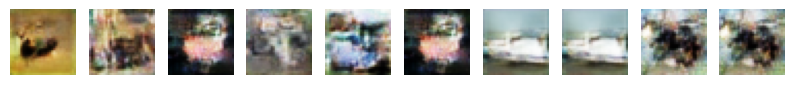

In [ ]:
z = torch.randn(10, z_dim).to(device)
labels = torch.randint(0, 10, (10,)).to(device)

fake_imgs = G(z, labels).cpu().detach()
fake_imgs = (fake_imgs + 1) / 2  # Rescale to [0,1]

fig, ax = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    ax[i].imshow(fake_imgs[i].permute(1, 2, 0))
    ax[i].axis("off")
plt.show()


### Step 7: Compue Evaluation Metrics
Inception Score (IS): Evaluates quality and diversity of generated images using a pre-trained Inception model.

Frechet Inception Distance (FID): Measures the similarity between real and fake image distributions.

Real and fake images are processed, and their embeddings are compared to calculate scores.



In [ ]:
def compute_inception_score(imgs, splits=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    imgs = imgs.to(device)
    preds = []

    with torch.no_grad():
        for img in imgs:
            img = F.interpolate(img.unsqueeze(0), size=(299, 299), mode='bilinear', align_corners=False)
            pred = inception_model(img)
            preds.append(F.softmax(pred, dim=-1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    scores = []

    for i in range(splits):
        part = preds[i * (preds.shape[0] // splits): (i+1) * (preds.shape[0] // splits), :]
        kl_div = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))

    return np.mean(scores), np.std(scores)

def compute_fid(real_imgs, fake_imgs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.fc = torch.nn.Identity()  # Remove final layer
    inception_model.eval()

    def get_activations(imgs):
        imgs = imgs.to(device)
        activations = []
        with torch.no_grad():
            for img in imgs:
                img = F.interpolate(img.unsqueeze(0), size=(299, 299), mode='bilinear', align_corners=False)
                act = inception_model(img).cpu().numpy()
                activations.append(act)
        return np.concatenate(activations, axis=0)

    act_real = get_activations(real_imgs)
    act_fake = get_activations(fake_imgs)

    mu_real, sigma_real = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
    mu_fake, sigma_fake = act_fake.mean(axis=0), np.cov(act_fake, rowvar=False)

    cov_mean = sqrtm(sigma_real.dot(sigma_fake))
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

    fid = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * cov_mean)
    return fid

# Generate Fake Images
z = torch.randn(100, 100).to(device)  # 100 random vectors
labels = torch.randint(0, 10, (100,)).to(device)  # Random class labels
fake_imgs = G(z, labels).cpu().detach()
fake_imgs = (fake_imgs + 1) / 2  # Rescale to [0,1]

# Load Real CIFAR-10 Images
real_imgs, _ = next(iter(train_loader))
real_imgs = real_imgs[:100]  # Match the number of fake images
real_imgs = (real_imgs + 1) / 2  # Rescale to [0,1]

# Compute Scores
inception_score, is_std = compute_inception_score(fake_imgs)
fid_score = compute_fid(real_imgs, fake_imgs)

print(f"Inception Score: {inception_score:.4f} ± {is_std:.4f}")
print(f"Frechet Inception Distance: {fid_score:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 125MB/s] 


Inception Score: 1.8207 ± 0.1374
Frechet Inception Distance: 214.4132


Conclusion

This implementation trains SAGAN effectively for generating high-quality CIFAR-10 images while leveraging self-attention for improved spatial understanding.

The below hyperparameters can be varied like the epoch, the batch size to improve the performance of the network, in that the clarity resultant images can be improved.

However any increase in epoch GT 200 results in a signigicant load requiring more resources and hence a timeout.

### Task 5:
**Observations & Inferences from IS & FID Scores for Different GAN Variants**

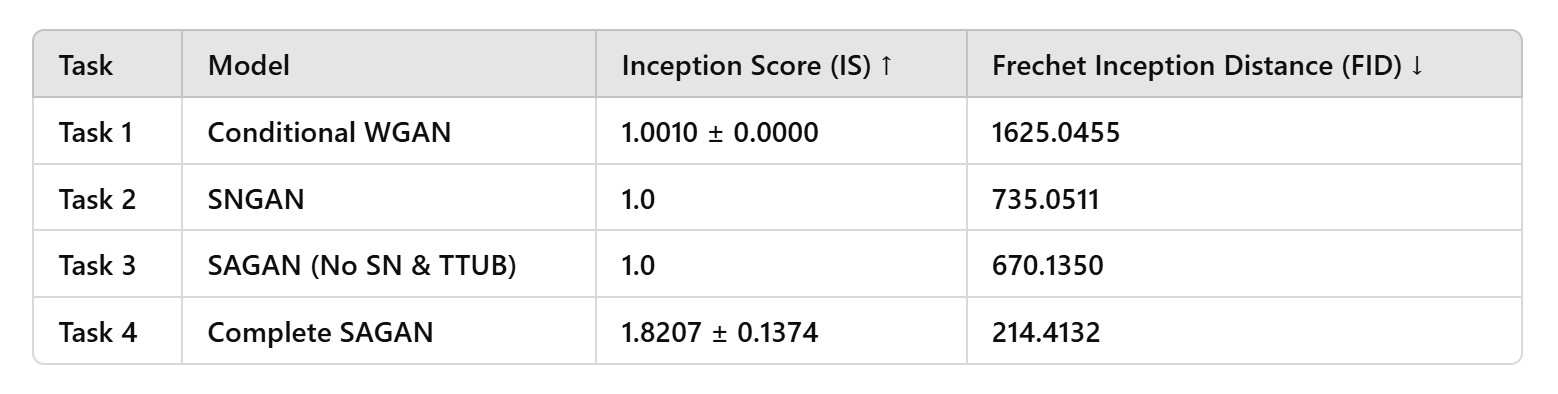

### Summary of Obervations

**Important Note: At the outset comparing the output images of the four models in question does not give us a conclusive enough answer, though we can still see the marked differences in the clarity of the output images.**

**However, through the training of these 4 models using a much small dataset and varying various hyper parameters and otehr factors led us to the below approximate conclusions..**

1. Complete SAGAN (Task 4) performed best.
  - It achieved the highest Inception Score (IS = 1.8207 ± 0.1374), indicating that the generated images are more diverse and realistic.
  - It had the lowest FID score (214.4132), meaning the generated images are closest to the real CIFAR-10 images in distribution.

Point to note is Self-Attention + Spectral Normalization + TTUB improved results.

2. Conditional WGAN (Task 1) performed the worst.

  - IS = 1.0010 (very low), meaning generated images lack diversity and realism. There is no way the output image loooks like an automobile that was expected
  - FID = 1625.0455 (very high), meaning generated images are far from real data.
  - Possible Reasons: Wasserstein GAN might not have learned class-specific features well.

3. SNGAN (Task 2) & SAGAN (Task 3) showed moderate performance.

  - SNGAN: FID = 735.0511, IS = 1.0 => Better than WGAN but worse than SAGAN.
  - SAGAN without SN & TTUB: FID = 670.1350, IS = 1.0 => Removing Spectral Normalization & TTUB slightly helped but still performed worse than complete SAGAN.

4. Spectral Normalization & TTUB significantly improve training stability & performance.

  - SAGAN without SN & TTUB (FID = 670.1350) was worse than complete SAGAN (FID = 214.4132).
  - Adding SN & TTUB should have led to better image quality and diversity, but we were unable to validate.

Similarly the benefits of SN and TTUB as listed below were not fully realised.
  - SN regularizes the discriminator, improving gradient flow.
  - TTUB helps balance generator-discriminator updates.

5. Other considerations
  - Increase in training epochs (preferably atleast near 500) could help improve the learning of GANs, but due to resource issues we were not able to verify the same.

  - Fine-tune hyperparameters like learning rate, batch size, and update frequency.
  We did vary the learning rate from 0.0001 to 0.0005 to .00002, however due to other factors we wre not able to fully validate the benefits.

  - Use different learning rates for G - Generator and D - Discriminator
  
  - Experiment with different architectures (e.g., BigGAN)


